In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
ec_mudata = md.read("../data/preprocessed/ec_mudata_prepro.h5mu")
ec_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 1166 × 4204
  3 modalities
    all_genes:	1166 x 2102
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'
    high_abundance_genes:	1166 x 387
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'
    low_abundance_genes:	1166 x 1715
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'

### Mean and Median of cell counts

In [3]:
print(np.mean(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=1)))
print(np.median(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=1)))

20.268438
17.0


### Mean and Median of gene counts

In [4]:
print(np.mean(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=0)))
print(np.median(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=0)))

61.067184
22.0


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


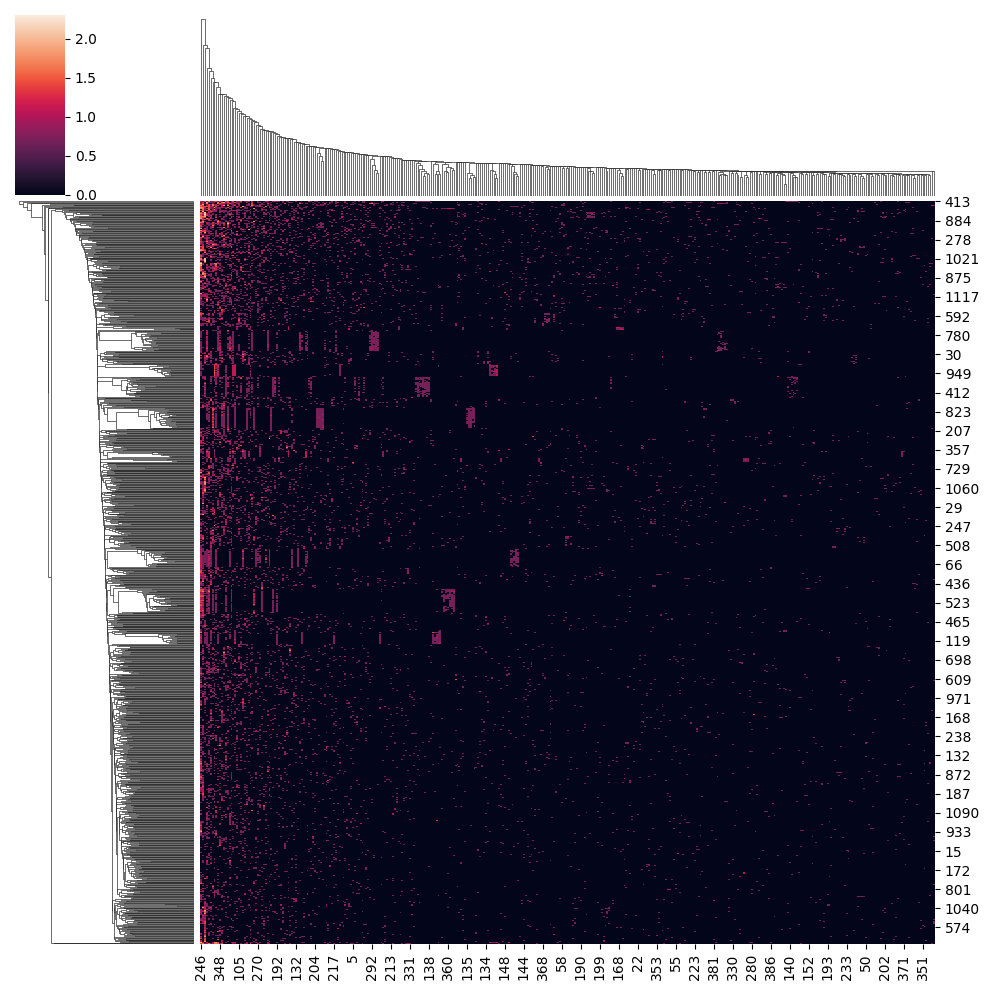

In [5]:
sns.clustermap(np.log1p(ec_mudata["high_abundance_genes"].X.A))

In [6]:
sc.pp.highly_variable_genes(ec_mudata["high_abundance_genes"], layer='raw_counts', n_top_genes=ec_mudata["high_abundance_genes"].shape[1], flavor='seurat_v3')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='highly_variable_rank', ylabel='total_counts'>

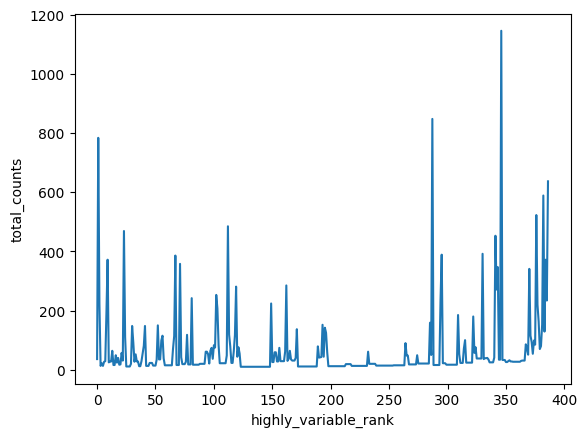

In [7]:
sns.lineplot(data=ec_mudata["high_abundance_genes"].var, x="highly_variable_rank", y="total_counts", color="C0")

### 200 HVG
Selecting the 200 (most) Highly Variables Genes for analysis

In [8]:
hag10_hcc15_hvg200 = ec_mudata["high_abundance_genes"][:, ec_mudata["high_abundance_genes"].var["highly_variable_rank"] <= 200].copy()
hag10_hcc15_hvg200

AnnData object with n_obs × n_vars = 1166 × 201
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    obsp: 'connectivities', 'distances'

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

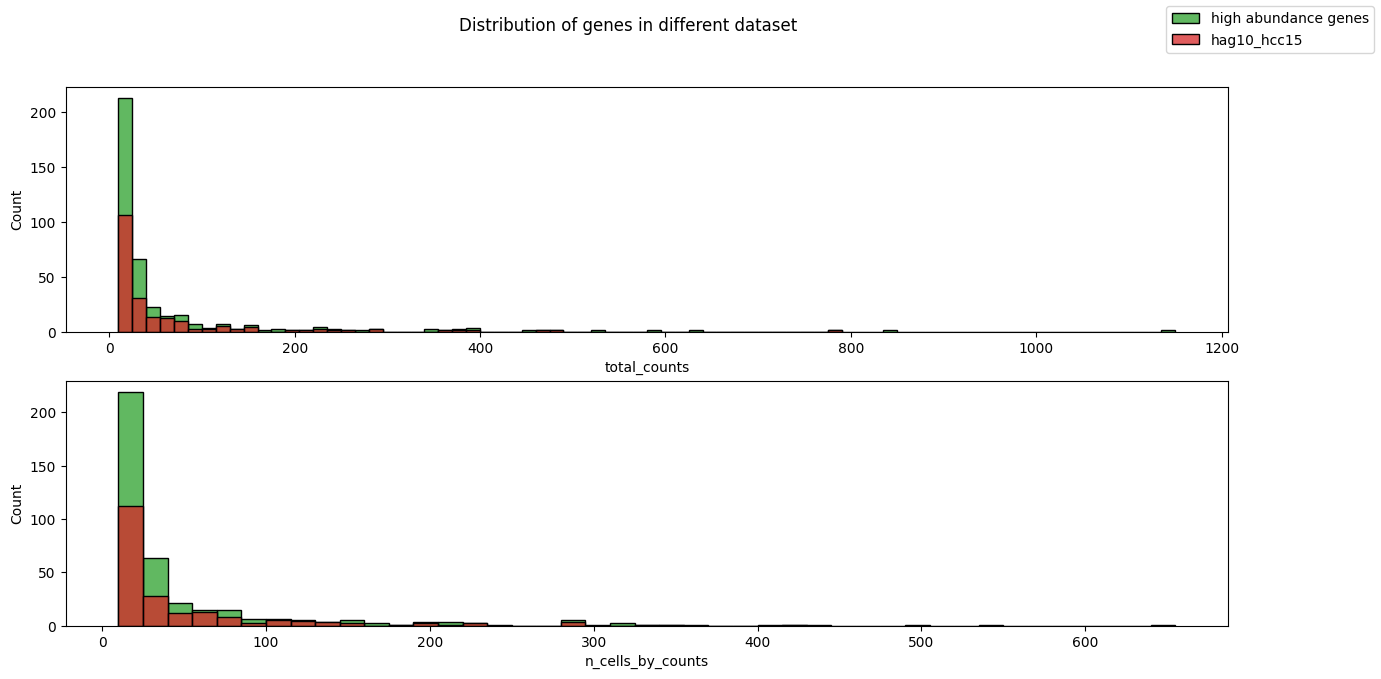

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))
sns.histplot(ec_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])
sns.histplot(hag10_hcc15_hvg200.var["total_counts"], binwidth=15, kde=False, color="C3", label="hag10_hcc15", ax=axes[0])

sns.histplot(ec_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])
sns.histplot(hag10_hcc15_hvg200.var["n_cells_by_counts"], binwidth=15, kde=False, color="C3", ax=axes[1])

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of counts in each cell')

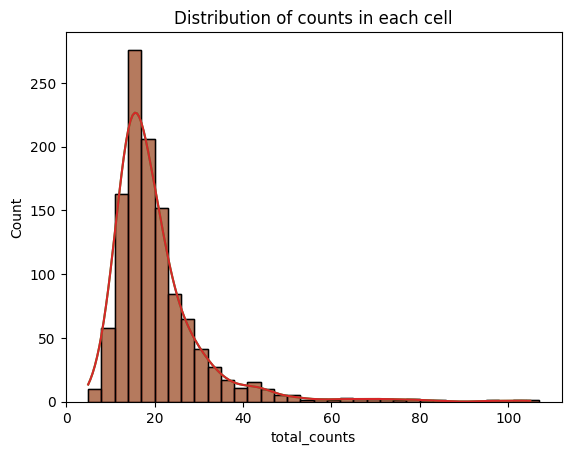

In [10]:
#fig, axes = plt.subplots(1, 1, figsize=(15,7))

sns.histplot(ec_mudata["high_abundance_genes"].obs["total_counts"], binwidth=3, kde=True, color="C2", label="high abundance genes",)
sns.histplot(hag10_hcc15_hvg200.obs["total_counts"], binwidth=3, kde=True, color="C3", label="hag10_hcc15",)

plt.title("Distribution of counts in each cell")

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


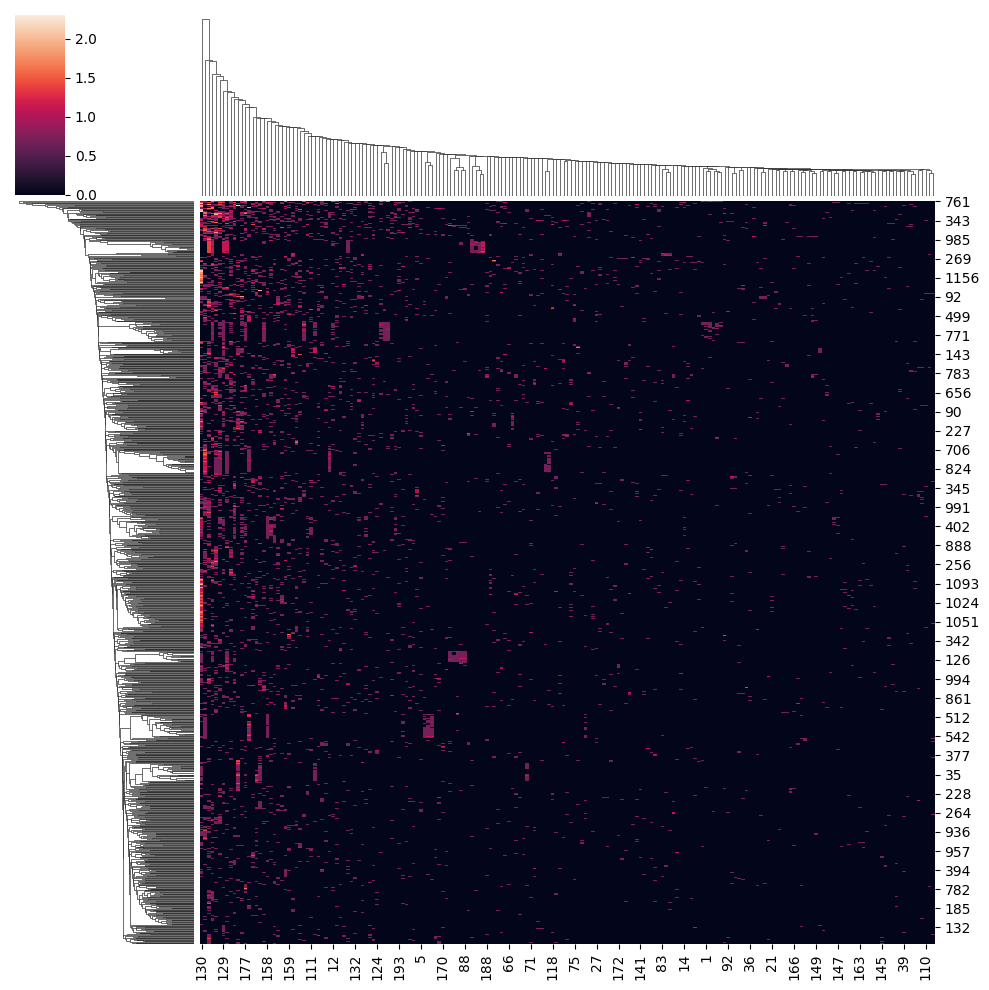

In [11]:
sns.clustermap(np.log1p(hag10_hcc15_hvg200.X.A))

In [12]:
calc_sparsity(np.array(hag10_hcc15_hvg200.X.A,dtype=bool))

0.0404282191102805

In [13]:
cov_hag10_hcc15_hvg200 = empirical_covariance(hag10_hcc15_hvg200.layers["sqrt_counts"].A)

In [14]:
ggl_est = gg_lasso_network_analysis(N=hag10_hcc15_hvg200.shape[0], estimate=cov_hag10_hcc15_hvg200)
ggl_est.create_problem(latent=False)
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 38 iterations with status: optimal.
ADMM terminated after 55 iterations with status: optimal.
ADMM terminated after 61 iterations with status: optimal.
ADMM terminated after 59 iterations with status: optimal.
ADMM terminated after 49 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 53 iterations wi

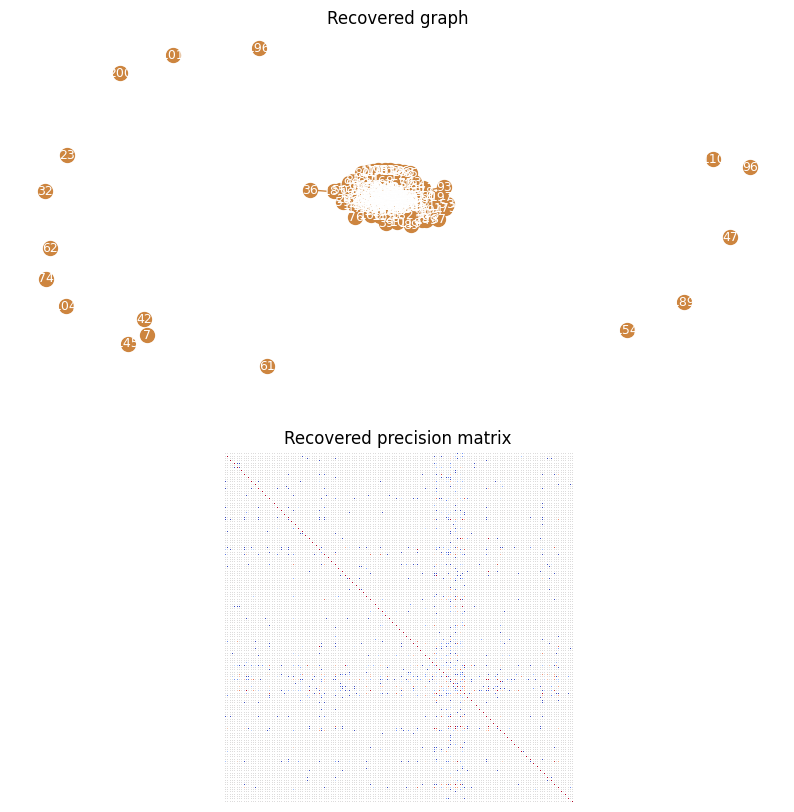

In [15]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

In [16]:
sol = ggl_est.P.solution.precision_

In [17]:
np.eye(3) * (-1)

array([[-1., -0., -0.],
       [-0., -1., -0.],
       [-0., -0., -1.]])

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


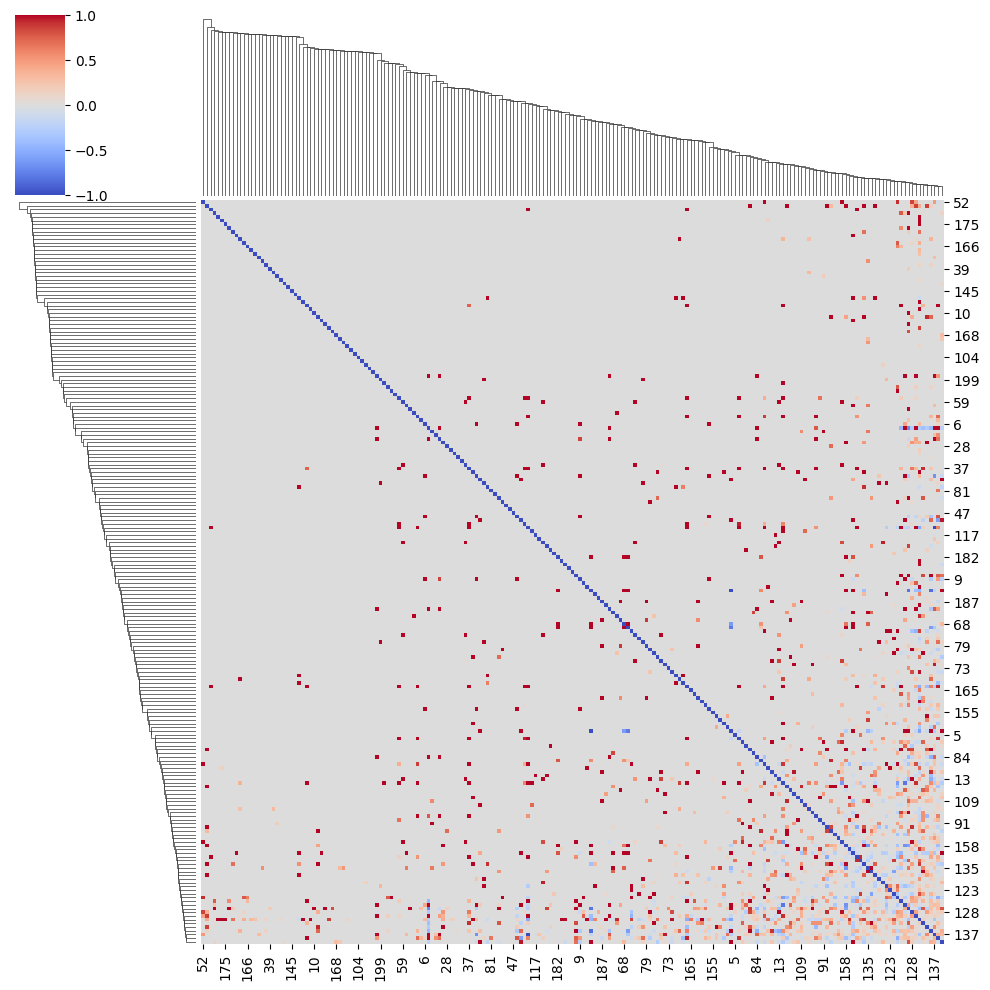

In [18]:
res = sns.clustermap(sol * (-1), cmap="coolwarm", vmin=-1, vmax=1)

In [18]:
ggl_est.P.__dict__

{'S': array([[ 0.01103587, -0.00013162, -0.00052716, ..., -0.00018262,
         -0.00010957, -0.00010957],
        [-0.00013162,  0.01271167, -0.00061208, ..., -0.00021204,
         -0.00012723, -0.00012723],
        [-0.00052716, -0.00061208,  0.04814881, ..., -0.00084928,
         -0.00050957, -0.00050957],
        ...,
        [-0.00018262, -0.00021204, -0.00084928, ...,  0.01857371,
         -0.00017653, -0.00017653],
        [-0.00010957, -0.00012723, -0.00050957, ..., -0.00017653,
          0.01018568, -0.00010592],
        [-0.00010957, -0.00012723, -0.00050957, ..., -0.00017653,
         -0.00010592,  0.01018568]]),
 'N': 1166,
 'latent': False,
 'G': None,
 'do_scaling': False,
 'conforming': True,
 'multiple': False,
 'p': 201,
 'K': 1,
 'reg_params': {'lambda1': 0.0036543830709572546, 'mu1': 0},
 'modelselect_params': {'lambda1_range': array([1.00000000e+00, 9.43787828e-01, 8.90735464e-01, 8.40665289e-01,
         7.93409667e-01, 7.48810386e-01, 7.06718127e-01, 6.66991966e-0

In [19]:
res.dendrogram_row.reordered_ind[:10]

[52, 57, 4, 30, 85, 179, 175, 11, 100, 149]

In [20]:
index_high_corr = hag10_hcc15_hvg200.var.index[res.dendrogram_row.reordered_ind[:10]]
index_high_corr

Index(['cds-NP_309742.1', 'cds-NP_309776.1', 'cds-NP_308085.1',
       'cds-NP_308611.1', 'cds-NP_311319.1', 'cds-NP_313051.2',
       'cds-NP_312923.1', 'cds-NP_308177.1', 'cds-NP_311839.1',
       'cds-NP_312391.1'],
      dtype='object')

In [21]:
hag10_hcc15_hvg200[:,index_high_corr].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
cds-NP_309742.1,GSM5456504_Efm_CDS,match,NP_309742.1,10,0.008576,99.142367,10.0,10,True,137.0,0.008576,0.00851,0.998371
cds-NP_309776.1,GSM5456504_Efm_CDS,match,NP_309776.1,10,0.008576,99.142367,10.0,10,True,135.0,0.008576,0.00851,0.998371
cds-NP_308085.1,GSM5456504_Efm_CDS,match,NP_308085.1,10,0.008576,99.142367,10.0,10,True,141.0,0.008576,0.00851,0.998371
cds-NP_308611.1,GSM5456504_Efm_CDS,match,NP_308611.1,10,0.008576,99.142367,10.0,10,True,139.0,0.008576,0.00851,0.998371
cds-NP_311319.1,GSM5456504_Efm_CDS,match,NP_311319.1,10,0.008576,99.142367,10.0,10,True,131.0,0.008576,0.00851,0.998371
cds-NP_313051.2,GSM5456505_PsA_CDS,match,NP_313051.2,10,0.008576,99.142367,10.0,10,True,145.0,0.008576,0.00851,0.998371
cds-NP_312923.1,GSM5456505_PsA_CDS,match,NP_312923.1,10,0.008576,99.142367,10.0,10,True,146.0,0.008576,0.00851,0.998371
cds-NP_308177.1,GSM5456504_Efm_CDS,match,NP_308177.1,10,0.008576,99.142367,10.0,10,True,148.0,0.008576,0.00851,0.998371
cds-NP_311839.1,GSM5456505_PsA_CDS,match,NP_311839.1,10,0.008576,99.142367,10.0,10,True,125.0,0.008576,0.00851,0.998371
cds-NP_312391.1,GSM5456505_PsA_CDS,match,NP_312391.1,10,0.008576,99.142367,10.0,10,True,124.0,0.008576,0.00851,0.998371


In [22]:
hag10_hcc15_hvg200[:,28].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
cds-NP_308520.1,GSM5456504_Efm_CDS,match,NP_308520.1,14,0.012864,98.799314,15.0,14,True,64.0,0.012864,0.014427,1.083628


In [23]:
hag10_hcc15_hvg200.var.total_counts.value_counts()

total_counts
10.0     26
11.0     21
15.0      7
17.0      7
22.0      7
         ..
119.0     1
83.0      1
114.0     1
117.0     1
53.0      1
Name: count, Length: 79, dtype: int64